### 1. Data Preprocessing

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [2]:
dir = Path('archive/test')
filepaths = list(dir.glob('**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath', dtype=str)
labels = pd.Series(labels, name='Label', dtype=str)

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,archive\test\F\F0.png,F
1,archive\test\F\F104.png,F
2,archive\test\F\F113.png,F
3,archive\test\F\F115.png,F
4,archive\test\F\F118.png,F
...,...,...
24794,archive\test\V\V98.png,V
24795,archive\test\V\V981.png,V
24796,archive\test\V\V986.png,V
24797,archive\test\V\V987.png,V


In [3]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

### 2. Data Balancing

In [4]:
import pandas as pd

# Define the target sample size for each category
target_sample_size = 160

# Initialize a list to store the sampled data for each category
samples = []

# List of categories to consider
categories = ['N', 'M', 'Q', 'V', 'S', 'F']

# Loop through each category
for category in categories:
    # Filter the dataframe to get data points belonging to the current category
    category_data = dataframe_test[dataframe_test['Label'] == category]
    
    # Check if the category has enough data points to take a sample of size 160
    if len(category_data) >= target_sample_size:
        # If yes, take a random sample of size 160 from the category
        sampled_data = category_data.sample(target_sample_size, random_state=1)
    else:
        # If not, take a sample of size equal to the number of data points available for that category
        sampled_data = category_data.sample(len(category_data), random_state=1)
    
    # Append the sampled data to the 'samples' list
    samples.append(sampled_data)

# Concatenate the sampled data for all categories
dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

# Check the sample size for each category
sample_sizes = dataframe_test['Label'].value_counts()
print(sample_sizes)

M    160
F    160
Q    160
N    160
V    160
S    160
Name: Label, dtype: int64


In [5]:
dataframe_test

,Filepath,Label
0,archive\test\M\M933.png,M
1,archive\test\F\F377.png,F
2,archive\test\Q\Q6746.png,Q
3,archive\test\Q\Q883.png,Q
4,archive\test\Q\Q6569.png,Q
...,...,...
955,archive\test\S\S1979.png,S
956,archive\test\N\N26059.png,N
957,archive\test\F\F418.png,F
958,archive\test\M\M971.png,M


### 3. Image Preprocessing and Data Augmentation

In [6]:
def gray_torgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
    image = cv2.merge((image, image, image))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

In [7]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,
    rescale=1./255
)

In [8]:
size = 224
color_mode = 'rgb'
batch_size = 32

test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,        # Input dataframe containing file paths and labels
    x_col='Filepath',                # Name of the dataframe column containing file paths
    y_col='Label',                   # Name of the dataframe column containing labels
    target_size=(size, size),        # Target size for resizing the images
    color_mode=color_mode,           # Color mode for the images
    class_mode='categorical',        # Type of label encoding ('categorical' for one-hot encoded labels)
    batch_size=batch_size,           # Number of images in each batch
    shuffle=False                    # No shuffle of data during testing
)

Found 960 validated image filenames belonging to 6 classes.


In [9]:
test_images.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

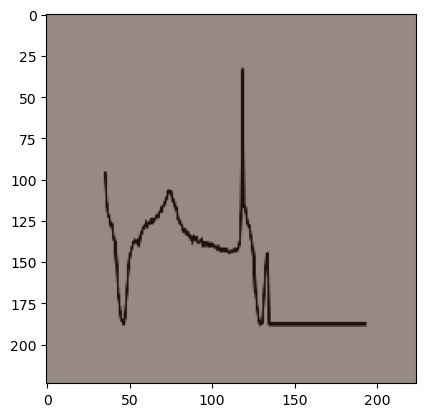

In [10]:
plt.imshow(test_images[0][0][3])

### 4. Model Evaluation

In [11]:
from keras.models import load_model

def load_model(model_path):
    best_model = load_model(model_path)
    return best_model

In [12]:
from keras.models import load_model

def evaluate_model(model_path, test_images):
    # Load the pre-trained model
    best_model = load_model(model_path)
    
    # Evaluate the model on the test images
    results = best_model.evaluate(test_images, verbose=0)
    
    # Print the evaluation results
    print('Test Loss     : {:.4f}'.format(results[0]))
    print('Test Accuracy : {:.4f}%'.format(results[1] * 100))
    print('Test Precision: {:.4f}%'.format(results[2] * 100))
    print('Test Recall   : {:.4f}%'.format(results[3] * 100))
    print('Test AUC      : {:.4f}'.format(results[4]))

evaluate_model('ECG_Model.h5', test_images)

Test Loss     : 0.1783
Test Accuracy : 94.3750%
Test Precision: 94.3633%
Test Recall   : 94.1667%
Test AUC      : 0.9963


### 5. Predictions

In [13]:
best_model = load_model('ECG_Model.h5')
y_pred = best_model.predict(test_images)
y_pred

30/30 [==============================] - 38s 1s/step


array([[6.1773893e-09, 9.9703503e-01, 3.5667172e-25, 1.5771217e-18,
        2.9649311e-03, 5.0325596e-08],
       [9.1034162e-01, 6.4489345e-06, 1.9912672e-09, 8.2269806e-05,
        1.0594049e-03, 8.8510223e-02],
       [2.2161191e-03, 6.6794842e-10, 2.4809726e-03, 9.7923386e-01,
        3.0703323e-08, 1.6068969e-02],
       ...,
       [9.0325695e-01, 2.7953147e-06, 1.5775734e-08, 2.6986437e-04,
        5.7464076e-04, 9.5895708e-02],
       [1.3756889e-09, 9.9778700e-01, 3.2295378e-27, 1.0131074e-19,
        2.2129999e-03, 2.9697132e-08],
       [1.4155057e-05, 1.1781427e-12, 9.0245605e-01, 9.7504579e-02,
        3.4286840e-12, 2.5159747e-05]], dtype=float32)

In [14]:
# Convert the predicted probabilities to class labels
# np.argmax() is used to find the index of the maximum probability along the specified axis (axis=1 in this case).
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 3, 3, 3, 1, 5, 1, 2, 2, 5, 3, 1, 2, 4, 4, 2, 4, 5, 2, 1, 3,
       4, 2, 4, 4, 4, 3, 2, 5, 3, 1, 2, 3, 2, 3, 4, 5, 4, 5, 0, 5, 1, 3,
       1, 4, 1, 4, 1, 0, 2, 2, 0, 3, 3, 0, 5, 0, 4, 0, 3, 5, 2, 5, 3, 0,
       5, 3, 1, 5, 1, 5, 5, 0, 5, 3, 0, 2, 0, 2, 0, 0, 4, 3, 2, 5, 2, 4,
       5, 5, 4, 5, 0, 1, 4, 2, 4, 1, 4, 2, 5, 2, 4, 5, 4, 4, 1, 0, 1, 4,
       3, 4, 4, 5, 2, 2, 2, 3, 3, 3, 0, 2, 4, 0, 1, 3, 4, 1, 1, 5, 4, 5,
       2, 4, 2, 0, 3, 3, 2, 0, 1, 2, 1, 3, 0, 0, 4, 3, 2, 1, 5, 3, 0, 4,
       1, 2, 1, 3, 0, 3, 3, 5, 5, 3, 1, 1, 4, 0, 3, 0, 5, 4, 1, 1, 0, 5,
       2, 5, 0, 2, 5, 0, 1, 3, 4, 4, 4, 1, 4, 2, 1, 4, 3, 4, 4, 4, 0, 0,
       5, 1, 5, 0, 5, 0, 1, 2, 0, 2, 4, 0, 0, 3, 0, 4, 2, 4, 1, 0, 5, 0,
       0, 0, 3, 2, 1, 2, 0, 5, 2, 4, 1, 2, 4, 0, 5, 2, 5, 0, 4, 1, 3, 2,
       4, 4, 0, 5, 0, 3, 2, 3, 2, 4, 2, 3, 4, 4, 3, 3, 0, 5, 4, 0, 2, 1,
       5, 1, 3, 2, 5, 5, 1, 0, 3, 5, 0, 2, 0, 1, 4, 5, 1, 4, 0, 0, 2, 3,
       3, 2, 0, 5, 4, 3, 1, 2, 1, 0, 1, 0, 5, 2, 3,

### 6. Confusion Matrix and Classification Report

In [15]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def generate_report_and_save_csv(test_labels, predictions, target_names, report_path, digits=4):
    cm = confusion_matrix(test_labels, predictions)
    print('Confusion Matrix:')
    print(cm)

    report = classification_report(test_labels, predictions, target_names=target_names, digits=digits)
    print('\nClassification Report:')
    print(report)

    report_df = report_to_df(report)

    report_df.to_csv(report_path, index=True)
    print(f'Report saved as {report_path}')


def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name'] + [x for x in report[0] if x != '']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value != '']
        if row:
            values.append(row)
    df = pd.DataFrame(data=values, columns=header)
    return df


generate_report_and_save_csv(
    test_images.labels, y_pred, target_names=['F', 'M', 'N', 'Q', 'S', 'V'], report_path='classification_report.csv', digits=4
)

Confusion Matrix:
[[149   0   0   0   0  11]
 [  0 147   0   0  13   0]
 [  0   0 158   2   0   0]
 [  0   0   1 159   0   0]
 [  2   5   0   0 152   1]
 [ 19   0   0   0   0 141]]

Classification Report:
              precision    recall  f1-score   support

           F     0.8765    0.9313    0.9030       160
           M     0.9671    0.9187    0.9423       160
           N     0.9937    0.9875    0.9906       160
           Q     0.9876    0.9938    0.9907       160
           S     0.9212    0.9500    0.9354       160
           V     0.9216    0.8812    0.9010       160

    accuracy                         0.9437       960
   macro avg     0.9446    0.9437    0.9438       960
weighted avg     0.9446    0.9437    0.9438       960

Report saved as classification_report.csv


### 7. Confusion Matrix Plotting

Confusion Matrix, without normalization


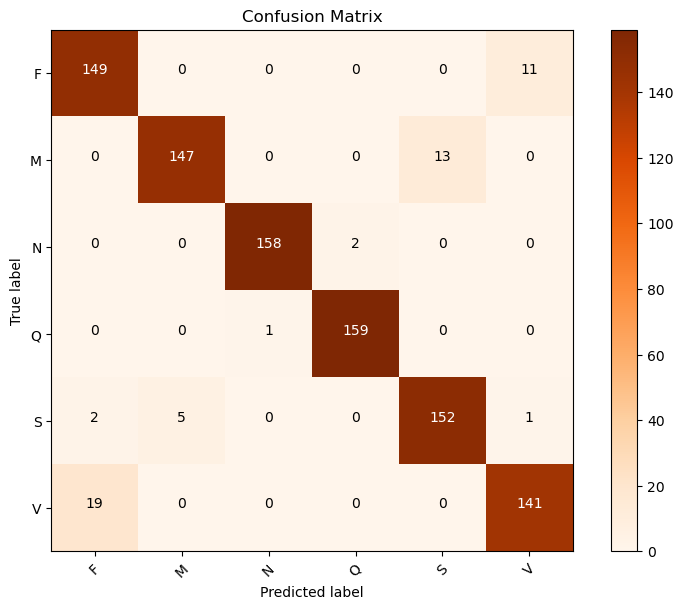

In [16]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, without normalization')
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.rcParams['font.size'] = '20'

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix' + '.jpg', dpi=500, bbox_inches='tight')
    
cm = confusion_matrix(test_images.labels, y_pred)
plot_confusion_matrix(cm, classes=['F', 'M', 'N', 'Q', 'S', 'V'], normalize=False, title='Confusion Matrix')

Normalized Confusion Matrix


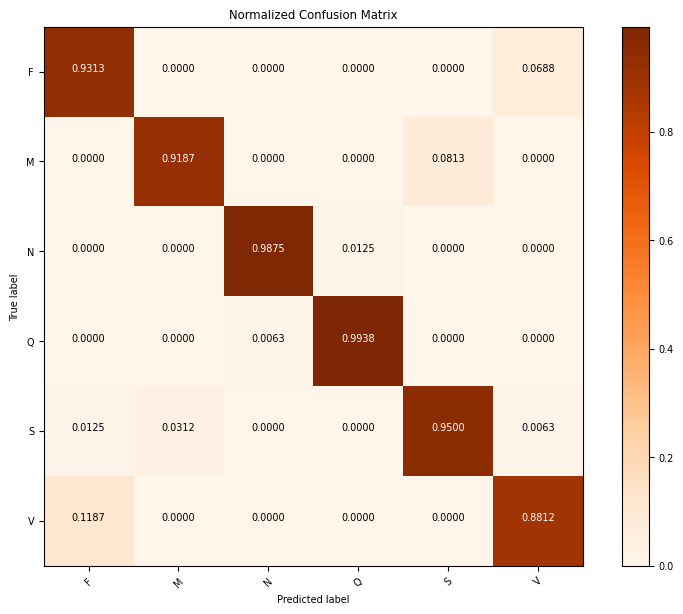

In [18]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.rcParams['font.size'] = '7'

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('normalized_confusion_matrix' + '.jpg', dpi=500, bbox_inches = 'tight')
    
cm = confusion_matrix(test_images.labels, y_pred)
plot_confusion_matrix(cm, classes=['F', 'M', 'N', 'Q', 'S', 'V'],normalize=True,title='Normalized Confusion Matrix')